# Análise de alunos do integrado do IFRN

a base de dados consiste em dados socioeconômicos e as notas finais de português e matemática do 1º e 2º ano. Essas disciplinas foram selecionadas devido a certeza delas estarem presente em todos os cursos de integrado ofertados no IFRN

In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#ESCALONAMENTO DE DADOS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split

#Evaluating
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

%matplotlib inline

#exibindo todas as colunas
pd.set_option('display.max_columns', None)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#definicao de funcoes que serao utilizadas

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

In [3]:
#importando base já tratada
dados = pd.read_json('dados_notas_col.json')
print(dados.id.nunique())
print(dados.shape)
dados.head(3)

6395
(6395, 34)


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaII90H,MatemticaI120H,MatemticaII90H,ano_letivo__ano,ano_letivo__ano_matricula_periodo,cep,classe,data,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_encaminhamento,descricao_historico,descricao_historico_disciplina,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_situacao_matricula_periodo,descricao_trabalho_responsavel,id,media_final,nome_escola_ensino_fundamental,percentual_frequencia,pessoa_fisica__nascimento_data,pessoa_fisica__sexo,professores,qnt_pc,qtd_pessoas_domicilio,renda_bruta_familiar,sigla
0,86,-1,87,-1,2016,2016,59067-400,1,05/05/2017,Matriculado,Urbana,Pais,Diálogo com professor(a),Técnico de Nível Médio em Edificações,Língua Portuguesa e Literatura I(90H),Financiado,Pós graduação incompleto,Pós graduação completo,Parda,Pós graduação completo,Pai,Aprovado,Serviço público,496915657473,86,Complexo Educacional Contemporâneo,85.0,06/12/2001,M,[1521],NaN,4,9000.0,CNAT
100002,69,-1,5,-1,2015,2016,59795-000,1,None,Matriculado,Urbana,Mãe,None,"Técnico de Nivel Médio em Agropecuária, na For...",Língua Portuguesa e Literatura I(90H),Alugado,Ensino fundamental incompleto,Ensino médio completo,Branca,Ensino médio completo,Pai,Dependência,Autônomo,458905053917,69,Escola Estadual António Francisco,92.0,16/12/1999,M,"[2688, 3538, 1222]",0.0,3,500.0,AP
100021,83,-1,77,-1,2016,2016,59200-000,1,None,Matriculado,Urbana,Pais,None,Técnico de Nivel Médio Informática,Língua Portuguesa e Literatura I(90H),Alugado,Ensino médio completo,Ensino médio incompleto,Branca,Ensino médio completo,Pai,Aprovado,Autônomo,496533683389,83,IESC,99.0,01/06/2000,F,"[1592, 3388]",0.0,7,2500.0,SC


In [4]:
#removendo colunas que explodem a quantidade de atributos quando binarizados
del dados['descricao_historico_disciplina']
del dados['professores']
del dados['id']
del dados['media_final']
del dados['percentual_frequencia']
del dados['nome_escola_ensino_fundamental']
del dados['qnt_pc']

#tentar colocar novamente
del dados['cep']
del dados['data']
del dados['pessoa_fisica__nascimento_data']

#sintetizar descricao_encaminhamento apenas se foi encaminhado ou nao
 
#dados que fazem a indicação se o aluno teve evasão
del dados['descricao']
del dados['descricao_situacao_matricula_periodo']

In [5]:
#configura os dados de entrada e saída
y = dados.classe
X = dados

del X['classe']
X.shape

(6395, 21)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


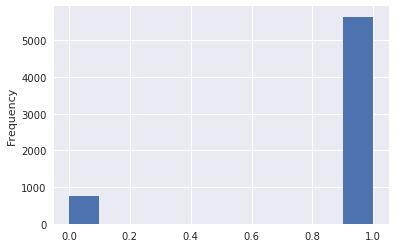

In [6]:
#visualizacao hist da classe
y.plot.hist()

In [6]:
#binazira os dados devido aos atributos categoricos 
dados_dummies = pd.get_dummies(X, drop_first=False)
dados_dummies.shape

(6395, 161)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


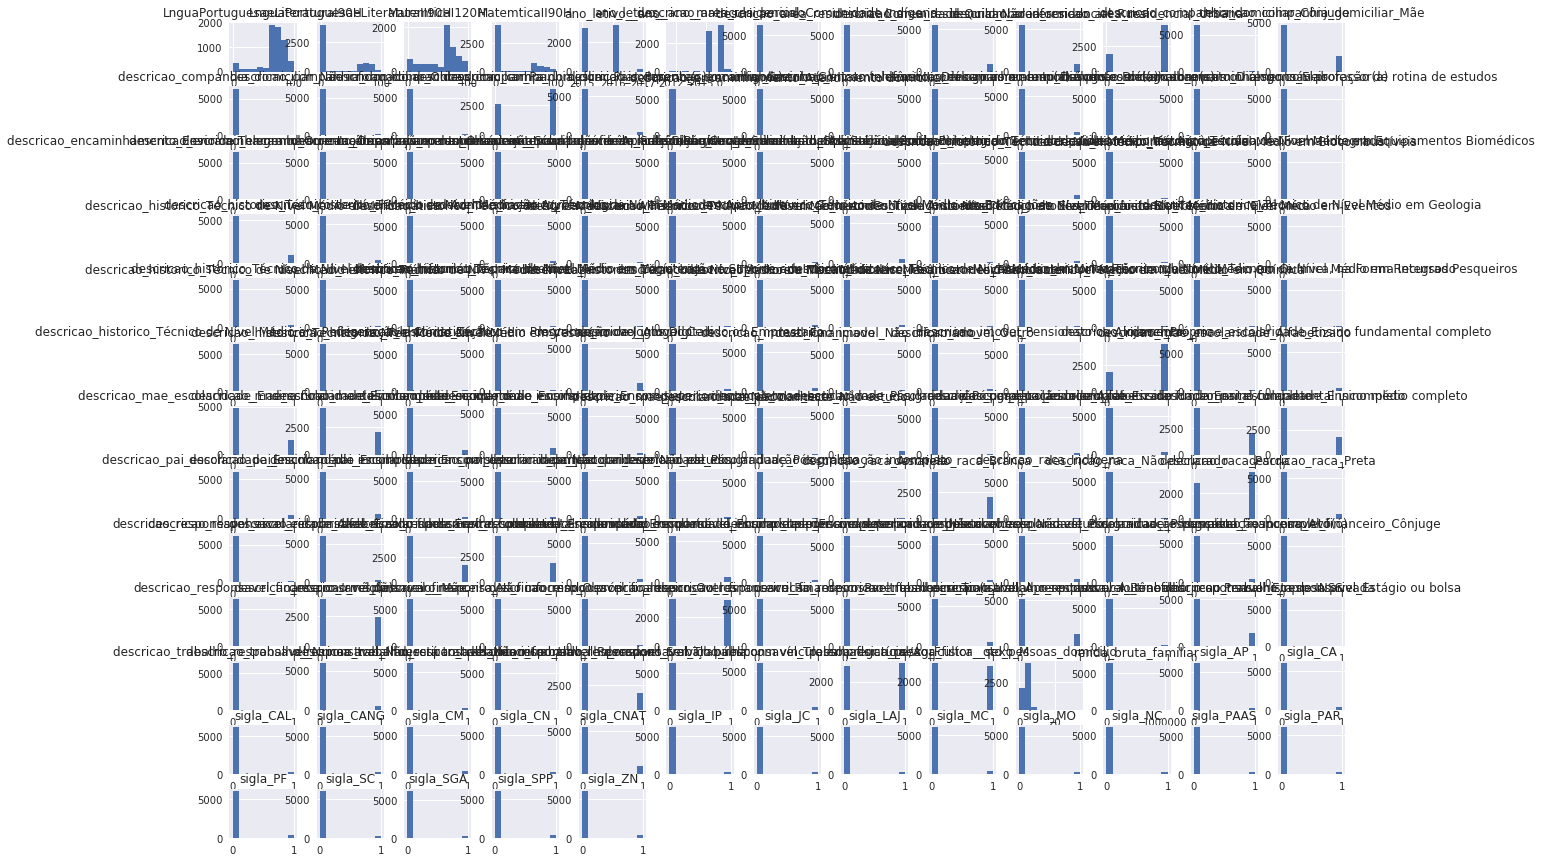

In [8]:
dados_dummies.hist(figsize=(20, 15))
plt.show()

In [7]:
#remove atributos inconistentes
dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
dados_clean = dados_clean.dropna(axis=1, how='all')
dados_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6395 entries, 0 to 99974
Columns: 161 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: float64(1), int64(7), uint8(153)
memory usage: 1.4 MB


In [10]:
#ESCALONAMENTO DE DADOS

#nao houve diferenças visivelmente

#dados_clean = StandardScaler().fit_transform(dados_clean) 
#dados_clean = MinMaxScaler().fit_transform(dados_clean) 
#dados_clean = RobustScaler(quantile_range=(25, 75)).fit_transform(dados_clean) 

In [11]:
#SELECIONANDO MELHOR MODEL RF

"""
param_grid = [    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},    
                  {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},  ]

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

forest_reg = RandomForestClassifier()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,                           
                           scoring='neg_mean_squared_error')
"""

#cria a randomforest 
forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 

param_grid_forest = {'max_depth': [3, 5, None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [10, 30, 60, 100, 200, 500, 1000],
              #'bootstrap': [True, False], #oob_score=True bootstrap só funciona com oob=true
              'criterion': ["gini", "entropy"]}

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)

#caso queira estratificar os dados
#StratifiedShuffleSplit

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest)
grid_search_forest.fit(Xtrain, ytrain)
print(grid_search_forest.best_params_)
print(grid_search_forest.best_estimator_)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs 

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)


In [12]:
#cvres = grid_search.cv_results_ 
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
#    print(np.sqrt(-mean_score), params) 
               
report(grid_search_forest.cv_results_, 5)

Model with rank: 1
Mean validation score: 0.922 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.921 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.921 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

Model with rank: 4
Mean validation score: 0.921 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 60}

Model with rank: 4
Mean validation score: 0.921 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}

Model with rank: 4
Mean validation score: 0.921 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

Model with rank: 4
Mean va

In [13]:
#RANDOM FOREST
"""
from sklearn.cross_validation import train_test_split

#cria e treina o modelo
Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)
model = RandomForestClassifier(n_estimators=30, random_state=42)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
"""

model_forest = grid_search_forest.best_estimator_
ypred_forest = model_forest.predict(Xtest)

0.940820443847
0.983134223472
0.940820443847
0.983134223472
0.961512027491
176


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


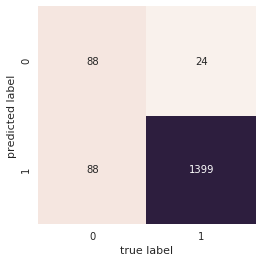

In [14]:
#Evaluating
mat = confusion_matrix(ytest, ypred_forest)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest, ypred_forest))
print(recall_score(ytest, ypred_forest))

#evaluating
print(precision_score(ytest, ypred_forest))
print(recall_score(ytest, ypred_forest))
print(f1_score(ytest, ypred_forest))

#qnt de evadidos 
print(sum(ytest==0))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


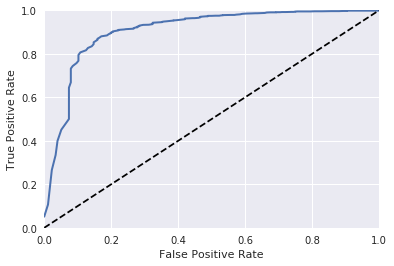

0.906347824698


In [15]:
#CURVA ROC

y_probas_forest = cross_val_predict(model_forest, Xtest, ytest, cv=3, method="predict_proba") 

y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ytest, y_scores_forest)

plot_roc_curve(fpr_forest, tpr_forest) 
plt.show()
print(roc_auc_score(ytest, y_scores_forest))

Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.173667)
2. feature 2 [MatemticaI120H] (0.102645)
3. feature 1 [LnguaPortuguesaeLiteraturaII90H] (0.059924)
4. feature 3 [MatemticaII90H] (0.047747)
5. feature 7 [renda_bruta_familiar] (0.047400)
6. feature 5 [ano_letivo__ano_matricula_periodo] (0.034352)
7. feature 4 [ano_letivo__ano] (0.026766)
8. feature 6 [qtd_pessoas_domicilio] (0.026445)
9. feature 10 [descricao_area_residencial_Não informado] (0.017957)
10. feature 12 [descricao_area_residencial_Urbana] (0.009865)
11. feature 101 [descricao_raca_Branca] (0.009410)
12. feature 151 [sigla_MC] (0.009370)
13. feature 140 [pessoa_fisica__sexo_M] (0.008728)
14. feature 104 [descricao_raca_Parda] (0.008534)
15. feature 139 [pessoa_fisica__sexo_F] (0.008420)
16. feature 41 [descricao_historico_Técnico de Nivel Médio em Informática] (0.008246)
17. feature 91 [descricao_pai_escolaridade_Ensino fundamental incompleto] (0.008214)
18. feature 18 [descricao_companhia_domiciliar_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


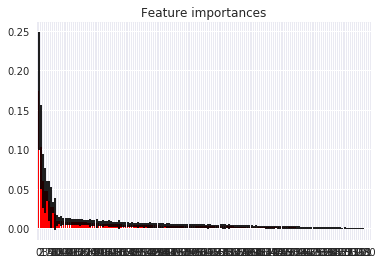

In [16]:
#FEATURES IMPORTANCE
"""
cont = 0
for name, score in zip(dados_clean.columns, model.feature_importances_):     
    print(name, score) 
    if cont > 10:
        break
    cont = cont + 1
"""

#fazer a qnt de importancia dos atributos
#print(cumsum(model.feature_importances_))

importances = model_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtest.shape[1]):
    print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], dados_clean.columns[indices[f]],importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtest.shape[1]), indices)
plt.xlim([-1, Xtest.shape[1]])
plt.show()

In [ ]:
#FIM RANDOM FOREST

In [17]:
#DECISION TREE

tree_clf = DecisionTreeClassifier() 

param_grid_tree = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_tree = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree)
grid_search_tree.fit(Xtrain, ytrain)
print(grid_search_tree.best_params_)
print(grid_search_tree.best_estimator_)

{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [18]:
report(grid_search_tree.cv_results_, 5)

model_tree = grid_search_tree.best_estimator_
ypred_tree = model_tree.predict(Xtest)

Model with rank: 1
Mean validation score: 0.921 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.921 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.921 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.921 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.921 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.921 (std: 0.006)
Para

In [18]:
#DECISION TREE
#from sklearn.tree import DecisionTreeClassifier
#Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)
#tree_clf = DecisionTreeClassifier(max_depth=3) 
#tree_clf.fit(Xtrain, ytrain)
#ypred = tree_clf.predict(Xtest)

0.925578486554
0.954038997214
0.9627547435
0.958377054914


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


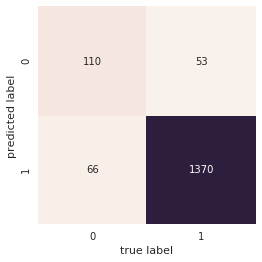

In [19]:
#porcentagem de predicao correta
n_correct = sum(ypred_tree == ytest)    
print(n_correct / len(ypred_tree)) 

#evaluating
mat = confusion_matrix(ytest, ypred_tree)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest, ypred_tree))
print(recall_score(ytest, ypred_tree))
print(f1_score(ytest, ypred_tree))

In [20]:
export_graphviz(model_tree,
                feature_names=dados_clean.columns,
                filled=True,
                rounded=True, 
                out_file='tree.dot')

os.system('dot -Tpng tree.dot -o tree.png')

0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


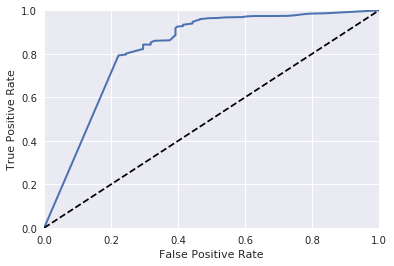

0.822703714943


In [22]:
y_probas_tree = cross_val_predict(model_tree, Xtest, ytest, cv=3, method="predict_proba") 

y_scores_tree = y_probas_tree[:, 1]   # score = proba of positive class 
fpr_tree, tpr_tree, thresholds_tree = roc_curve(ytest, y_scores_tree)

plot_roc_curve(fpr_tree, tpr_tree) 
plt.show()
print(roc_auc_score(ytest, y_scores_tree))

In [ ]:
#FIM DT

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


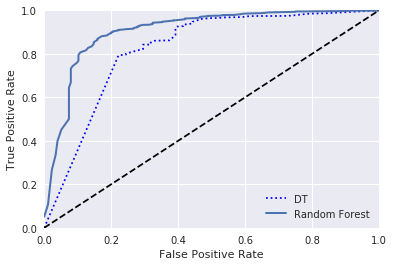

In [23]:
#PLOTAR DUAS CURVAS ROC (DT e RF)
plt.plot(fpr_tree, tpr_tree, "b:", label="DT") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="bottom right") 
plt.show()

In [ ]:
#FIM COMPARACAO

[  9.99994133e-01   4.19365608e-06]
(6395, 2)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


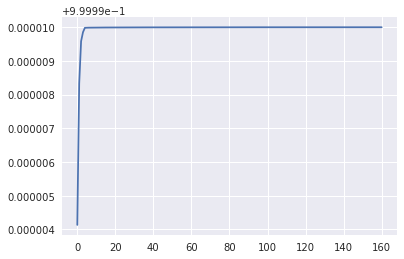

In [24]:
#REDUÇÃO DE DIMENSIONALIDADE

#pca = PCA(n_components=0.95) 
pca = PCA(n_components=2) 
X_reduced = pca.fit_transform(dados_clean) 

print(pca.explained_variance_ratio_) 
print(X_reduced.shape)

pca = PCA() 
pca.fit(dados_clean) 
cumsum = np.cumsum(pca.explained_variance_ratio_) 
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(cumsum)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


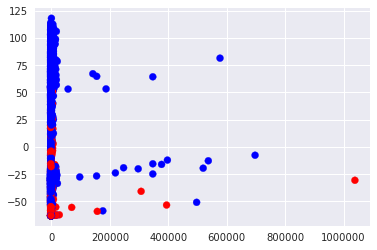

In [27]:
#X_reduced.shape

colors = ['red','blue']
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

In [28]:
#cria a randomforest 
#forest_pca = RandomForestClassifier(n_estimators=50, oob_score=True) 
forest_pca = RandomForestClassifier() 

param_grid_pca = {'max_depth': [3, 5, None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [10, 30, 60, 100, 200, 500, 1000],
              
              'criterion': ["gini", "entropy"]}


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_pca, Xtest_pca, ytrain_pca, ytest_pca = train_test_split(X_reduced, y, random_state=0)

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_pca = GridSearchCV(estimator=forest_pca, param_grid=param_grid_pca, cv = 5)
grid_search_pca.fit(Xtrain_pca, ytrain_pca)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, None], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [10, 30, 60, 100, 200, 500, 1000], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [29]:
print(grid_search_pca.best_params_)
print(grid_search_pca.best_estimator_)

#exibir melhor modelo
report(grid_search_pca.cv_results_, 5)

#seleciona o melhor modelo
model_pca = grid_search_pca.best_estimator_
ypred_pca = model_pca.predict(Xtest_pca)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Model with rank: 1
Mean validation score: 0.908 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.907 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.907 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}

Model with rank: 4
Mean validation score: 0.907 (std: 0.005)
Parameter

0.927090301003
0.973998594519
0.927090301003
0.973998594519
0.949965729952


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


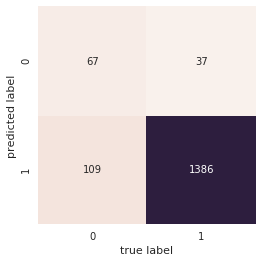

In [30]:
#Evaluating
mat = confusion_matrix(ytest_pca, ypred_pca)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_pca, ypred_pca))
print(recall_score(ytest_pca, ypred_pca))

#evaluating
print(precision_score(ytest_pca, ypred_pca))
print(recall_score(ytest_pca, ypred_pca))
print(f1_score(ytest_pca, ypred_pca))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


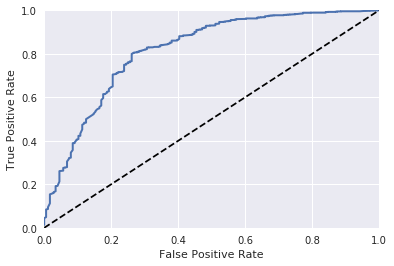

0.816608637322


In [31]:
#CURVA ROC
y_probas_pca = cross_val_predict(model_pca, Xtest_pca, ytest_pca, cv=3, method="predict_proba") 

y_scores_pca = y_probas_pca[:, 1]   # score = proba of positive class 
fpr_pca, tpr_pca, thresholds_pca = roc_curve(ytest_pca, y_scores_pca)

plot_roc_curve(fpr_pca, tpr_pca) 
plt.show()
print(roc_auc_score(ytest_pca, y_scores_pca))


In [ ]:
#FIM PCA

In [39]:
#BASE APENAS COM ALGUNS DADOS IMPORTANTES DA RF
"""
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.167594)
2. feature 2 [MatemticaI120H] (0.107503)
3. feature 1 [LnguaPortuguesaeLiteraturaII90H] (0.072414)
4. feature 3 [MatemticaII90H] (0.059724)
5. feature 7 [renda_bruta_familiar] (0.047050)
6. feature 5 [ano_letivo__ano_matricula_periodo] (0.032807)
7. feature 4 [ano_letivo__ano] (0.030889)
8. feature 6 [qtd_pessoas_domicilio] (0.024958)

dados_reduzido = dados_clean[['LnguaPortuguesaeLiteraturaI90H', 'MatemticaI120H', 
                              'LnguaPortuguesaeLiteraturaII90H', 'MatemticaII90H', 
                              'renda_bruta_familiar', 'ano_letivo__ano_matricula_periodo', 
                              'ano_letivo__ano', 'qtd_pessoas_domicilio']]
"""
dados_reduzido = dados_clean[['LnguaPortuguesaeLiteraturaI90H', 'MatemticaI120H', 
                              'LnguaPortuguesaeLiteraturaII90H', 'MatemticaII90H', 
                              'renda_bruta_familiar']]


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_red, Xtest_red, ytrain_red, ytest_red = train_test_split(dados_reduzido, y, random_state=0)



In [40]:
tree_clf = DecisionTreeClassifier() 

param_grid_tree_red = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_red = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree_red)
grid_search_red.fit(Xtrain_red, ytrain_red)
print(grid_search_red.best_params_)
print(grid_search_red.best_estimator_)

{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [41]:
report(grid_search_red.cv_results_, 5)

model_red = grid_search_red.best_estimator_
ypred_red = model_red.predict(Xtest_red)

Model with rank: 1
Mean validation score: 0.911 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.911 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.911 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 20}

Model with rank: 4
Mean validation score: 0.910 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 4
Mean validation score: 0.910 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 4
Mean validation score: 0.910 (std: 0.007)
Parameters:

0.913070669168
0.937329700272
0.966971187632
0.951919750951


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


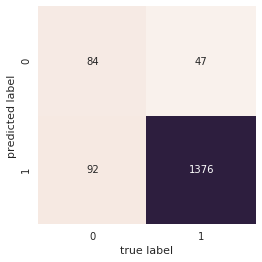

In [42]:
n_correct = sum(ypred_red == ytest_red)    
print(n_correct / len(ypred_red)) 

#evaluating
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest_red, ypred_red)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_red, ypred_red))
print(recall_score(ytest_red, ypred_red))
print(f1_score(ytest_red, ypred_red))

In [36]:
export_graphviz(model_red,
                feature_names=dados_reduzido.columns,
                filled=True,
                rounded=True, 
                out_file='tree_red.dot')

os.system('dot -Tpng tree_red.dot -o tree_red.png')

0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


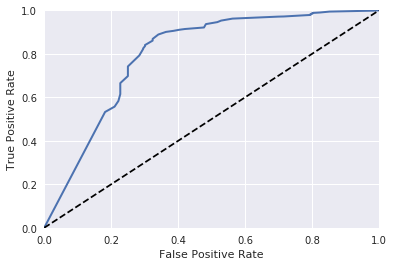

0.797980019805


In [43]:
y_probas_tree_red = cross_val_predict(model_red, Xtest_red, ytest_red, cv=3, method="predict_proba") 

y_scores_tree_red = y_probas_tree_red[:, 1]   # score = proba of positive class 
fpr_tree_red, tpr_tree_red, thresholds_tree_red = roc_curve(ytest_red, y_scores_tree_red)

plot_roc_curve(fpr_tree_red, tpr_tree_red) 
plt.show()
print(roc_auc_score(ytest_red, y_scores_tree_red))

{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model with rank: 1
Mean validation score: 0.910 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.910 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.910 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 20}

Model with rank: 4
Me

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


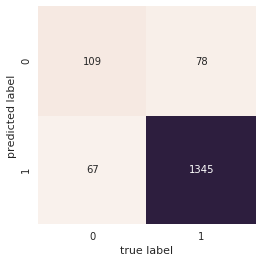

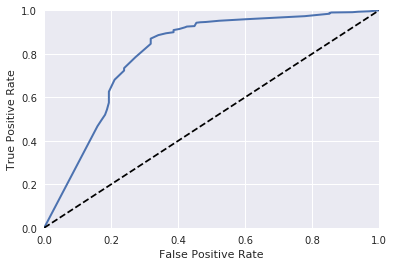

0.801910975532


In [46]:
dados_reduzido = dados_clean[['LnguaPortuguesaeLiteraturaI90H', 'MatemticaI120H', 
                              'LnguaPortuguesaeLiteraturaII90H', 'MatemticaII90H']]


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_red, Xtest_red, ytrain_red, ytest_red = train_test_split(dados_reduzido, y, random_state=0)

tree_clf = DecisionTreeClassifier() 

param_grid_tree_red = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_red = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree_red)
grid_search_red.fit(Xtrain_red, ytrain_red)
print(grid_search_red.best_params_)
print(grid_search_red.best_estimator_)

#mostra os melhores 5 modelos
report(grid_search_red.cv_results_, 5)

#realiza predicao
model_red = grid_search_red.best_estimator_
ypred_red = model_red.predict(Xtest_red)

#avalia modelo
n_correct = sum(ypred_red == ytest_red)    
print(n_correct / len(ypred_red)) 

#evaluating
mat = confusion_matrix(ytest_red, ypred_red)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_red, ypred_red))
print(recall_score(ytest_red, ypred_red))
print(f1_score(ytest_red, ypred_red))

#curva ROC
y_probas_tree_red = cross_val_predict(model_red, Xtest_red, ytest_red, cv=3, method="predict_proba") 

y_scores_tree_red = y_probas_tree_red[:, 1]   # score = proba of positive class 
fpr_tree_red, tpr_tree_red, thresholds_tree_red = roc_curve(ytest_red, y_scores_tree_red)

fig = plt.figure()

plot_roc_curve(fpr_tree_red, tpr_tree_red) 
plt.show()
print(roc_auc_score(ytest_red, y_scores_tree_red))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


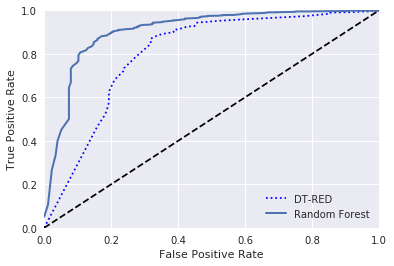

In [47]:
#PLOTAR DUAS CURVAS ROC (DT e RF)
plt.plot(fpr_tree_red, tpr_tree_red, "b:", label="DT-RED") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="bottom right") 
plt.show()

In [43]:
#FIM DT REDUZIDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6f19abd68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff6ef34c6a0>]], dtype=object)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


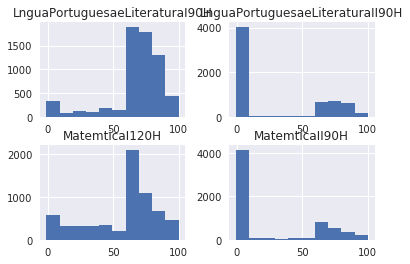

In [51]:
dados_reduzido.hist()

{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Model with rank: 1
Mean validation score: 0.907 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.907 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.906 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank:

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


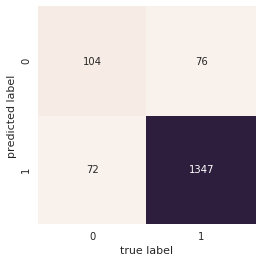

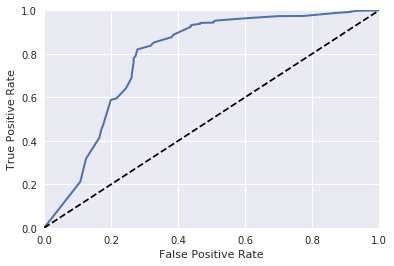

0.784987302753


In [23]:
#UTILIZANDO AS MÉDIAS DE CADA ANO

nota_1 = dados_clean[['LnguaPortuguesaeLiteraturaI90H', 'MatemticaI120H']].mean(axis=1)
nota_2 = dados_clean[['LnguaPortuguesaeLiteraturaII90H', 'MatemticaII90H']].mean(axis=1)

dados_reduzido = pd.DataFrame()
dados_reduzido['1_ano'] = nota_1
dados_reduzido['2_ano'] = nota_2


#dividir os dados para treino e teste. default é 25% p teste
Xtrain_red, Xtest_red, ytrain_red, ytest_red = train_test_split(dados_reduzido, y, random_state=0)

tree_clf = DecisionTreeClassifier() 

param_grid_tree_red = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_red = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree_red)
grid_search_red.fit(Xtrain_red, ytrain_red)
print(grid_search_red.best_params_)
print(grid_search_red.best_estimator_)

#mostra os melhores 5 modelos
report(grid_search_red.cv_results_, 5)

#realiza predicao
model_red = grid_search_red.best_estimator_
ypred_red = model_red.predict(Xtest_red)

#avalia modelo
n_correct = sum(ypred_red == ytest_red)    
print(n_correct / len(ypred_red)) 

#evaluating
mat = confusion_matrix(ytest_red, ypred_red)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_red, ypred_red))
print(recall_score(ytest_red, ypred_red))
print(f1_score(ytest_red, ypred_red))

#curva ROC
y_probas_tree_red = cross_val_predict(model_red, Xtest_red, ytest_red, cv=3, method="predict_proba") 

y_scores_tree_red = y_probas_tree_red[:, 1]   # score = proba of positive class 
fpr_tree_red, tpr_tree_red, thresholds_tree_red = roc_curve(ytest_red, y_scores_tree_red)

fig = plt.figure()

plot_roc_curve(fpr_tree_red, tpr_tree_red) 
plt.show()
print(roc_auc_score(ytest_red, y_scores_tree_red))

{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model with rank: 1
Mean validation score: 0.905 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.905 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.905 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}

Model with rank: 1
Mean validation s

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


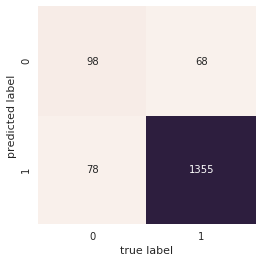

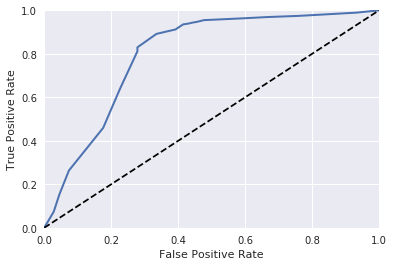

0.800878825145


In [24]:
#UTILIZANDO AS MÉDIAS POR DISCIPLINA

nota_1 = dados_clean[['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaII90H']].mean(axis=1)
nota_2 = dados_clean[['MatemticaI120H', 'MatemticaII90H']].mean(axis=1)

dados_reduzido = pd.DataFrame()
dados_reduzido['1_ano'] = nota_1
dados_reduzido['2_ano'] = nota_2

#dividir os dados para treino e teste. default é 25% p teste
Xtrain_red, Xtest_red, ytrain_red, ytest_red = train_test_split(dados_reduzido, y, random_state=0)

tree_clf = DecisionTreeClassifier() 

param_grid_tree_red = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_red = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree_red)
grid_search_red.fit(Xtrain_red, ytrain_red)
print(grid_search_red.best_params_)
print(grid_search_red.best_estimator_)

#mostra os melhores 5 modelos
report(grid_search_red.cv_results_, 5)

#realiza predicao
model_red = grid_search_red.best_estimator_
ypred_red = model_red.predict(Xtest_red)

#avalia modelo
n_correct = sum(ypred_red == ytest_red)    
print(n_correct / len(ypred_red)) 

#evaluating
mat = confusion_matrix(ytest_red, ypred_red)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest_red, ypred_red))
print(recall_score(ytest_red, ypred_red))
print(f1_score(ytest_red, ypred_red))

#curva ROC
y_probas_tree_red = cross_val_predict(model_red, Xtest_red, ytest_red, cv=3, method="predict_proba") 

y_scores_tree_red = y_probas_tree_red[:, 1]   # score = proba of positive class 
fpr_tree_red, tpr_tree_red, thresholds_tree_red = roc_curve(ytest_red, y_scores_tree_red)

fig = plt.figure()

plot_roc_curve(fpr_tree_red, tpr_tree_red) 
plt.show()
print(roc_auc_score(ytest_red, y_scores_tree_red))

In [38]:
#EDA DAS NOTAS 

dados_eda = dados[['descricao_mae_escolaridade', 'descricao_pai_escolaridade', 
                   'descricao_raca', 'pessoa_fisica__sexo', 
                   'renda_bruta_familiar', 'sigla']]

nota_1 = dados[['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaII90H']].mean(axis=1)
nota_2 = dados[['MatemticaI120H', 'MatemticaII90H']].mean(axis=1)

dados_eda['1_ano'] = nota_1
dados_eda['2_ano'] = nota_2
dados_eda['classe'] = y

dados_eda

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,pessoa_fisica__sexo,renda_bruta_familiar,sigla,1_ano,2_ano,classe
0,Pós graduação incompleto,Pós graduação completo,Parda,M,9000.00,CNAT,42.5,43.0,1
100002,Ensino fundamental incompleto,Ensino médio completo,Branca,M,500.00,AP,34.0,2.0,1
100021,Ensino médio completo,Ensino médio incompleto,Branca,F,2500.00,SC,41.0,38.0,1
100034,Ensino médio completo,Ensino médio completo,Parda,F,788.00,CA,86.0,75.0,1
10005,Ensino fundamental incompleto,Ensino superior completo,Parda,F,900.00,CNAT,37.5,15.5,1
100064,Ensino médio completo,Ensino médio completo,Parda,M,1760.00,CNAT,62.5,36.0,1
100095,Ensino médio completo,Ensino médio completo,Parda,M,900.00,CNAT,9.5,6.5,0
100108,Ensino fundamental completo,Ensino médio completo,Parda,F,2000.00,SC,88.5,86.0,1
100137,Ensino médio completo,Ensino médio completo,Branca,M,1500.00,CN,36.0,42.5,1
100153,Ensino superior completo,Ensino médio incompleto,Branca,M,2380.00,MO,68.5,65.0,1


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


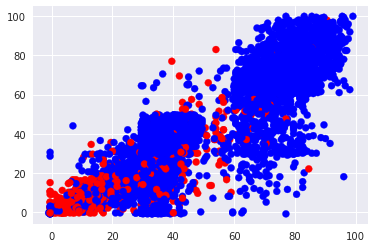

In [39]:
#plot eixo y media do primeiro ano, eixo x media do segundo. cores representando evasao ou nao
colors = ['red','blue']
plt.scatter(dados_eda.loc[:, '1_ano'], dados_eda.loc[:, '2_ano'], c=dados_eda['classe'], cmap=matplotlib.colors.ListedColormap(colors))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


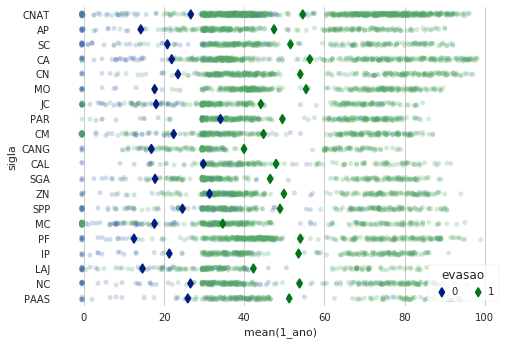

In [50]:
sns.set(style="whitegrid")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="1_ano", y="sigla", hue="classe",
              data=dados_eda, jitter=True,
              alpha=.25, zorder=1)

# Show the conditional means
sns.pointplot(x="1_ano", y="sigla", hue="classe",
              data=dados_eda, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title="evasao",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=2, frameon=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


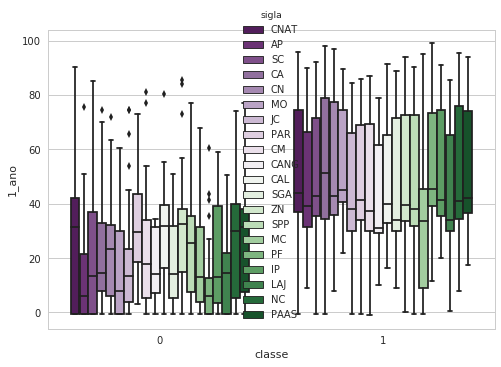

In [51]:
sns.boxplot(x="classe", y="1_ano", hue="sigla", data=dados_eda, palette="PRGn")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


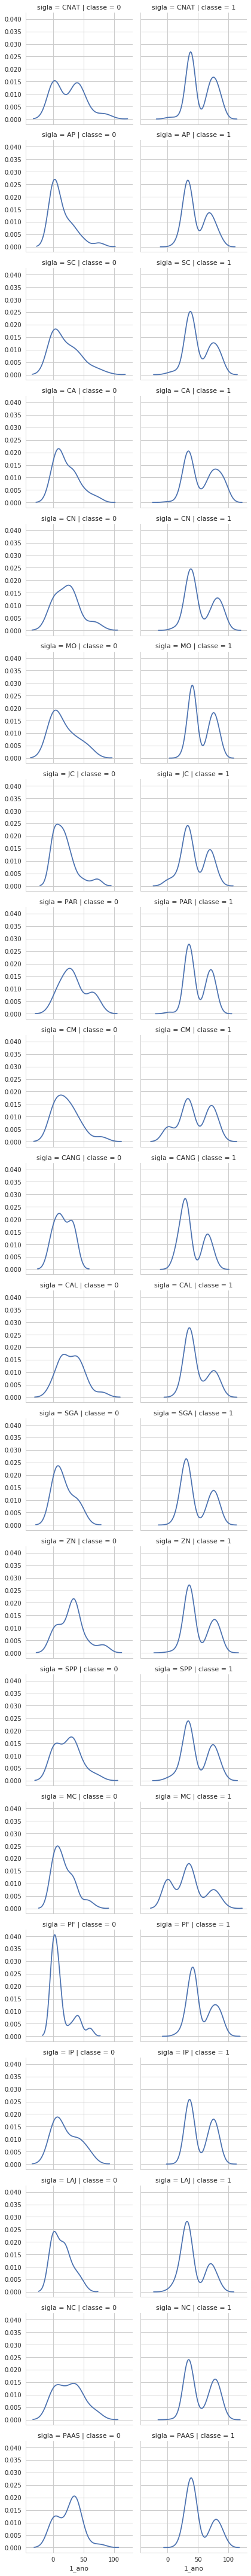

In [53]:
g = sns.FacetGrid(dados_eda, col="classe",  row="sigla")
g = g.map(sns.kdeplot, "1_ano")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


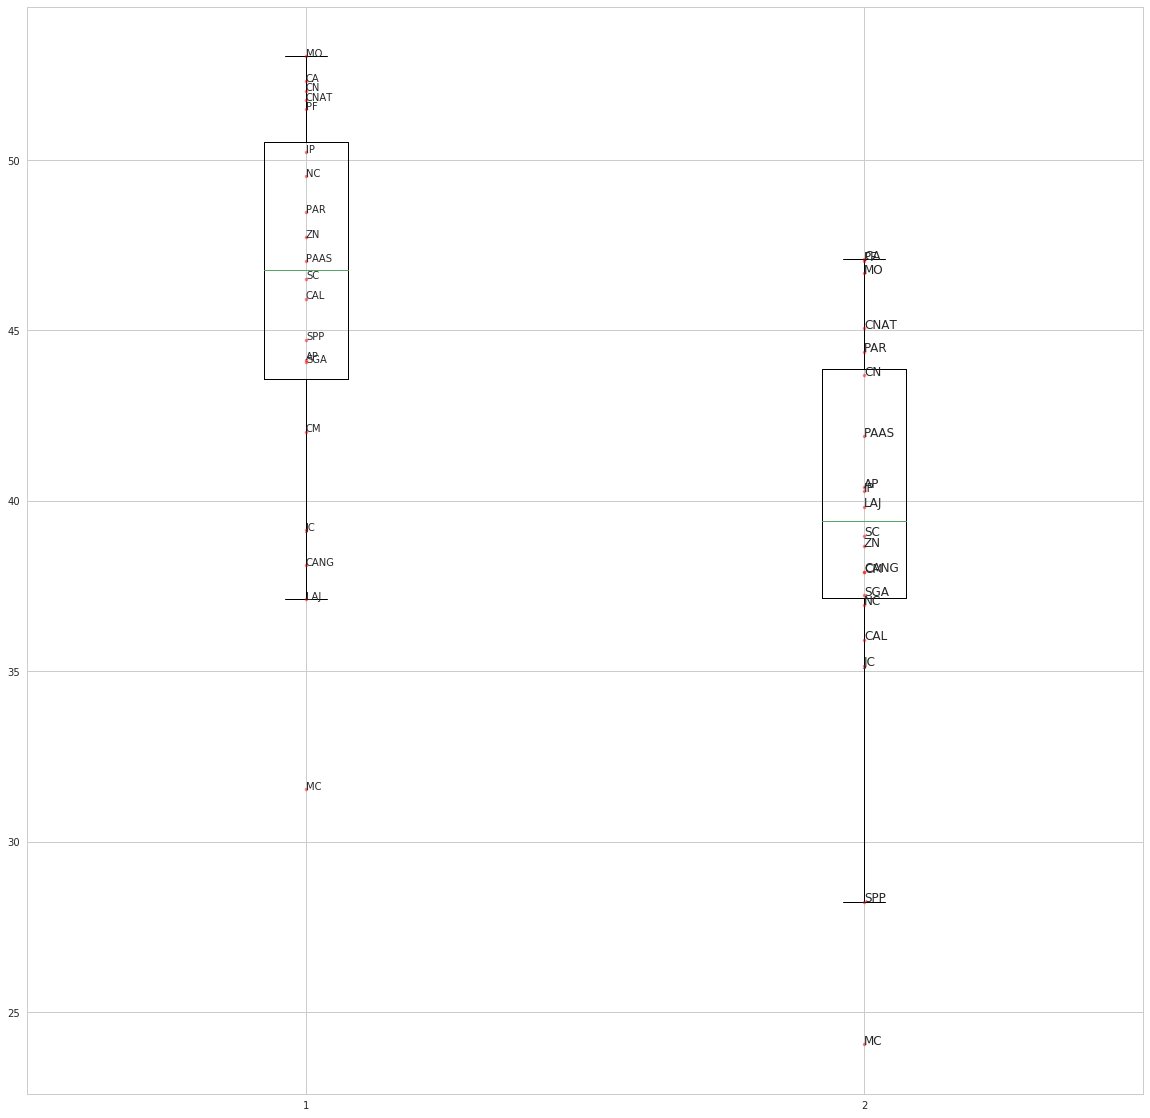

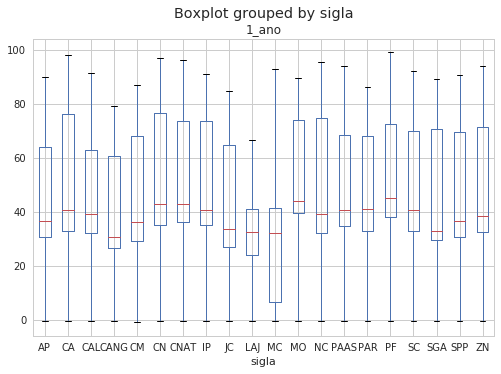

In [99]:
#print(dados_eda.groupby('sigla')['1_ano'].mean())
#print(dados_eda.groupby('sigla')['1_ano'].mean().index)

data_plot = [dados_eda.groupby('sigla')['1_ano'].mean(), dados_eda.groupby('sigla')['2_ano'].mean()]

fig, ax = plt.subplots(figsize=(20, 20))
plt.boxplot(data_plot)
plt.plot([1, 2], [dados_eda.groupby('sigla')['1_ano'].mean(), dados_eda.groupby('sigla')['2_ano'].mean()], 'r.', alpha=0.5)


for i, txt in enumerate( dados_eda.groupby('sigla')['1_ano'].mean().index ):
    ax.annotate( txt, (1, dados_eda.groupby('sigla')['1_ano'].mean()[i]), fontsize=10)
    ax.annotate( txt, (2, dados_eda.groupby('sigla')['2_ano'].mean()[i]) )


fig = plt.figure()
dados_eda.boxplot(column='1_ano',by='sigla')